Read the Seabird CTD profiles written as CVN files.

In [1]:
import os
import glob
import logging
import datetime
import calendar
import numpy as np
import matplotlib.pyplot as plt
from seabird.cnv import fCNV

In [37]:
logger = logging.getLogger()
logger.setLevel(logging.WARN)

In [50]:
lon0 = 8.74617
lat0 = 42.59653
figdir = "/home/ctroupin/PycharmProjects/Stareso-Data-Processing/figures/Profiles/"
datadir = "/home/ctroupin/Data/Stareso/CTD/"
#datadir = '/home/ctroupin/Data/Stareso/CTD/201705/'
outputdir = '/home/ctroupin/Data/Stareso/CTD'
datafilelist = sorted(glob.glob(os.path.join(datadir, "*.cnv")))
logging.info("Working on {0} files".format(len(datafilelist)))

In [46]:
class CNVprofile(object):
    """Profile object storing the profiles obtained from cnv files
    
    """
    
    def __init__(self, filename, varlist=None, values=None):
        self.filename = filename
        logging.debug("Working on {0}".format(filename))
        if varlist==None:
            self.varlist = []
        else:
            self.varlist = varlist
        if values==None:
            self.values = {}
            
    def read_from_file(self):
        """Read the variable names and the values from the specified file
        """
        nvars = len(self.varlist)
        
        # Initialise variable dictionnary
        for i in range(0, nvars):
            self.values[self.varlist[i]] = []
        
        with open(self.filename, 'r', encoding='latin-1') as f:
            # Read first line
            line = f.readline()

            # Read until end of header (could add regex at some point)
            while not line.rstrip() == "*END*":
                line = f.readline()
            logger.debug(line)

            # Read the column names
            line = f.readline()
            logger.debug(line)
            columnnames = line.rsplit()
            logger.debug("Column names: {0}".format(columnnames))
            
            line = f.readline()
            while line:
                data = line.rsplit()
                for i in range(0, nvars):
                    self.values[self.varlist[i]].append(float(data[i]))
                    line = f.readline()
                    
    def add_to_plot(self, varlist, **kwargs):
        """Add the specified variables to the figure
        
        Parameters
        varlist: list of variables (strings)
        """
        for variables in varlist[1:]:
            plt.plot(self.values[varlist[0]], self.values[variables], **kwargs)
            
    @property
    def get_date(self):
        """Get the date (datetime object) corresponding to the profile
        """
        fname = os.path.basename(self.filename)
        date = datetime.datetime(int(fname[:4]), int(fname[4:6]), int(fname[6:8]))
        logging.info("Date: {0}".format(date))
        return date

In [48]:
varlist = ['scan', 'depth', 'salinity', 'temperature', 
                        'conductivity', 'density', 'flag']
P = CNVprofile(datafilelist[0], varlist)
P.read_from_file()

# Write to a new file that ODV can read

In [51]:
with open(os.path.join(outputdir,"Stareso100m.txt"), 'w') as f:
    # Write header line (variable names and units)
    f.write("\t".join(("Scan", "Longitude [degrees_east]",
                       "Latitude [degrees_north]", "yyyy-mm-ddThh:mm:ss",
                       "Depth [Meter]", "Salinity [Practical Salinity Scale]",
                       "Temperature [Celsius]", "Conductivity [MicroSiemens per Centimeter]",
                       "Density [Kilograms per Cubic Meter]\n")))
    # Loop on the data files
    for datafile in datafilelist:
        P = CNVprofile(datafile, varlist)
        P.read_from_file()
        profiledate = P.get_date
        profiledatestring = datetime.datetime.strftime(profiledate, '%Y-%m-%dT00:00:00')
        ndepth = len(P.values['depth'])
        for i in range(0, ndepth):
            f.write("\t".join((str(i+1), str(lon0), str(lat0), profiledatestring, 
                               str(P.values['depth'][i]), 
                               str(P.values['salinity'][i]),
                               str(P.values['temperature'][i]),
                               str(P.values['conductivity'][i]),
                               str(P.values['density'][i]), "\n")))

# Make the plots

## One plot per profile

First with the older profiles:

In [52]:
varlist = ['scan', 'depth', 'salinity', 'temperature', 
                        'conductivity', 'density', 'flag']

In [53]:
for datafile in datafilelist:
    P = CNVprofile(datafile, varlist)
    P.read_from_file()
    P.add_to_plot(['temperature', 'depth'])
    plt.gca().invert_yaxis()
    plt.xlabel('Temperature ($^{\circ}C$)')
    plt.ylabel('Depth (m)', rotation=0, ha='right')
    profiledate = P.get_date
    plt.title(datetime.datetime.strftime(profiledate, '%Y-%m-%d'), fontsize=20)
    figname = os.path.basename(P.filename).split('.')[0]
    plt.savefig(os.path.join(figdir, figname), bbox_inches='tight')
    #plt.show()
    plt.close()

Then with the May 2017 profiles:

In [55]:
datadir2017 = "/home/ctroupin/Data/Stareso/CTD/201705/"
datafilelist2 = sorted(glob.glob(os.path.join(datadir2017, "201705*.cnv")))
varlist2017 = ['scan', 'depth', 'conductivity', 'temperature', 'salinity', 'flag']

In [57]:
for datafile in datafilelist2:
    P = CNVprofile(datafile, varlist2017)
    P.read_from_file()
    P.add_to_plot(['temperature', 'depth'])
    plt.gca().invert_yaxis()
    plt.xlabel('Temperature ($^{\circ}$C)')
    plt.ylabel('Depth (m)', rotation=0, ha='right')
    profiledate = P.get_date
    plt.title(datetime.datetime.strftime(profiledate, '%Y-%m-%d'), fontsize=20)
    figname = os.path.basename(P.filename).split('.')[0]
    plt.savefig(os.path.join(figdir, figname), bbox_inches='tight')
    #plt.show()
    plt.close()

Also write them to a file readable by ODV:

In [59]:
with open(os.path.join(outputdir,"Stareso100m_201705.txt"), 'w') as f:
    # Loop on the data files
    for datafile in datafilelist2:
        P = CNVprofile(datafile, varlist2017)
        P.read_from_file()
        profiledate = P.get_date
        profiledatestring = datetime.datetime.strftime(profiledate, '%Y-%m-%dT00:00:00')
        ndepth = len(P.values['depth'])
        for i in range(0, ndepth):
            f.write("\t".join((str(i+1), str(lon0), str(lat0), profiledatestring, 
                               str(P.values['depth'][i]), 
                               str(P.values['salinity'][i]),
                               str(P.values['temperature'][i]),
                               str(P.values['conductivity'][i]),
                               "-999.", "\n")))

## All the profiles on the same plot

In [139]:
fig = plt.figure()
for datafile in datafilelist:
    P = CNVprofile(datafile)
    P.read_from_file()
    P.add_to_plot(['temperature', 'depth'])
plt.gca().invert_yaxis()
plt.xlabel('Temperature ($^{\circ}$C)')
plt.ylabel('Depth (m)', rotation=0, ha='right')
figname = 'temperature_all'
plt.savefig(os.path.join(figdir, figname), bbox_inches='tight')
#plt.show()
plt.close()

## Scatter plot (time - depth - temperature)

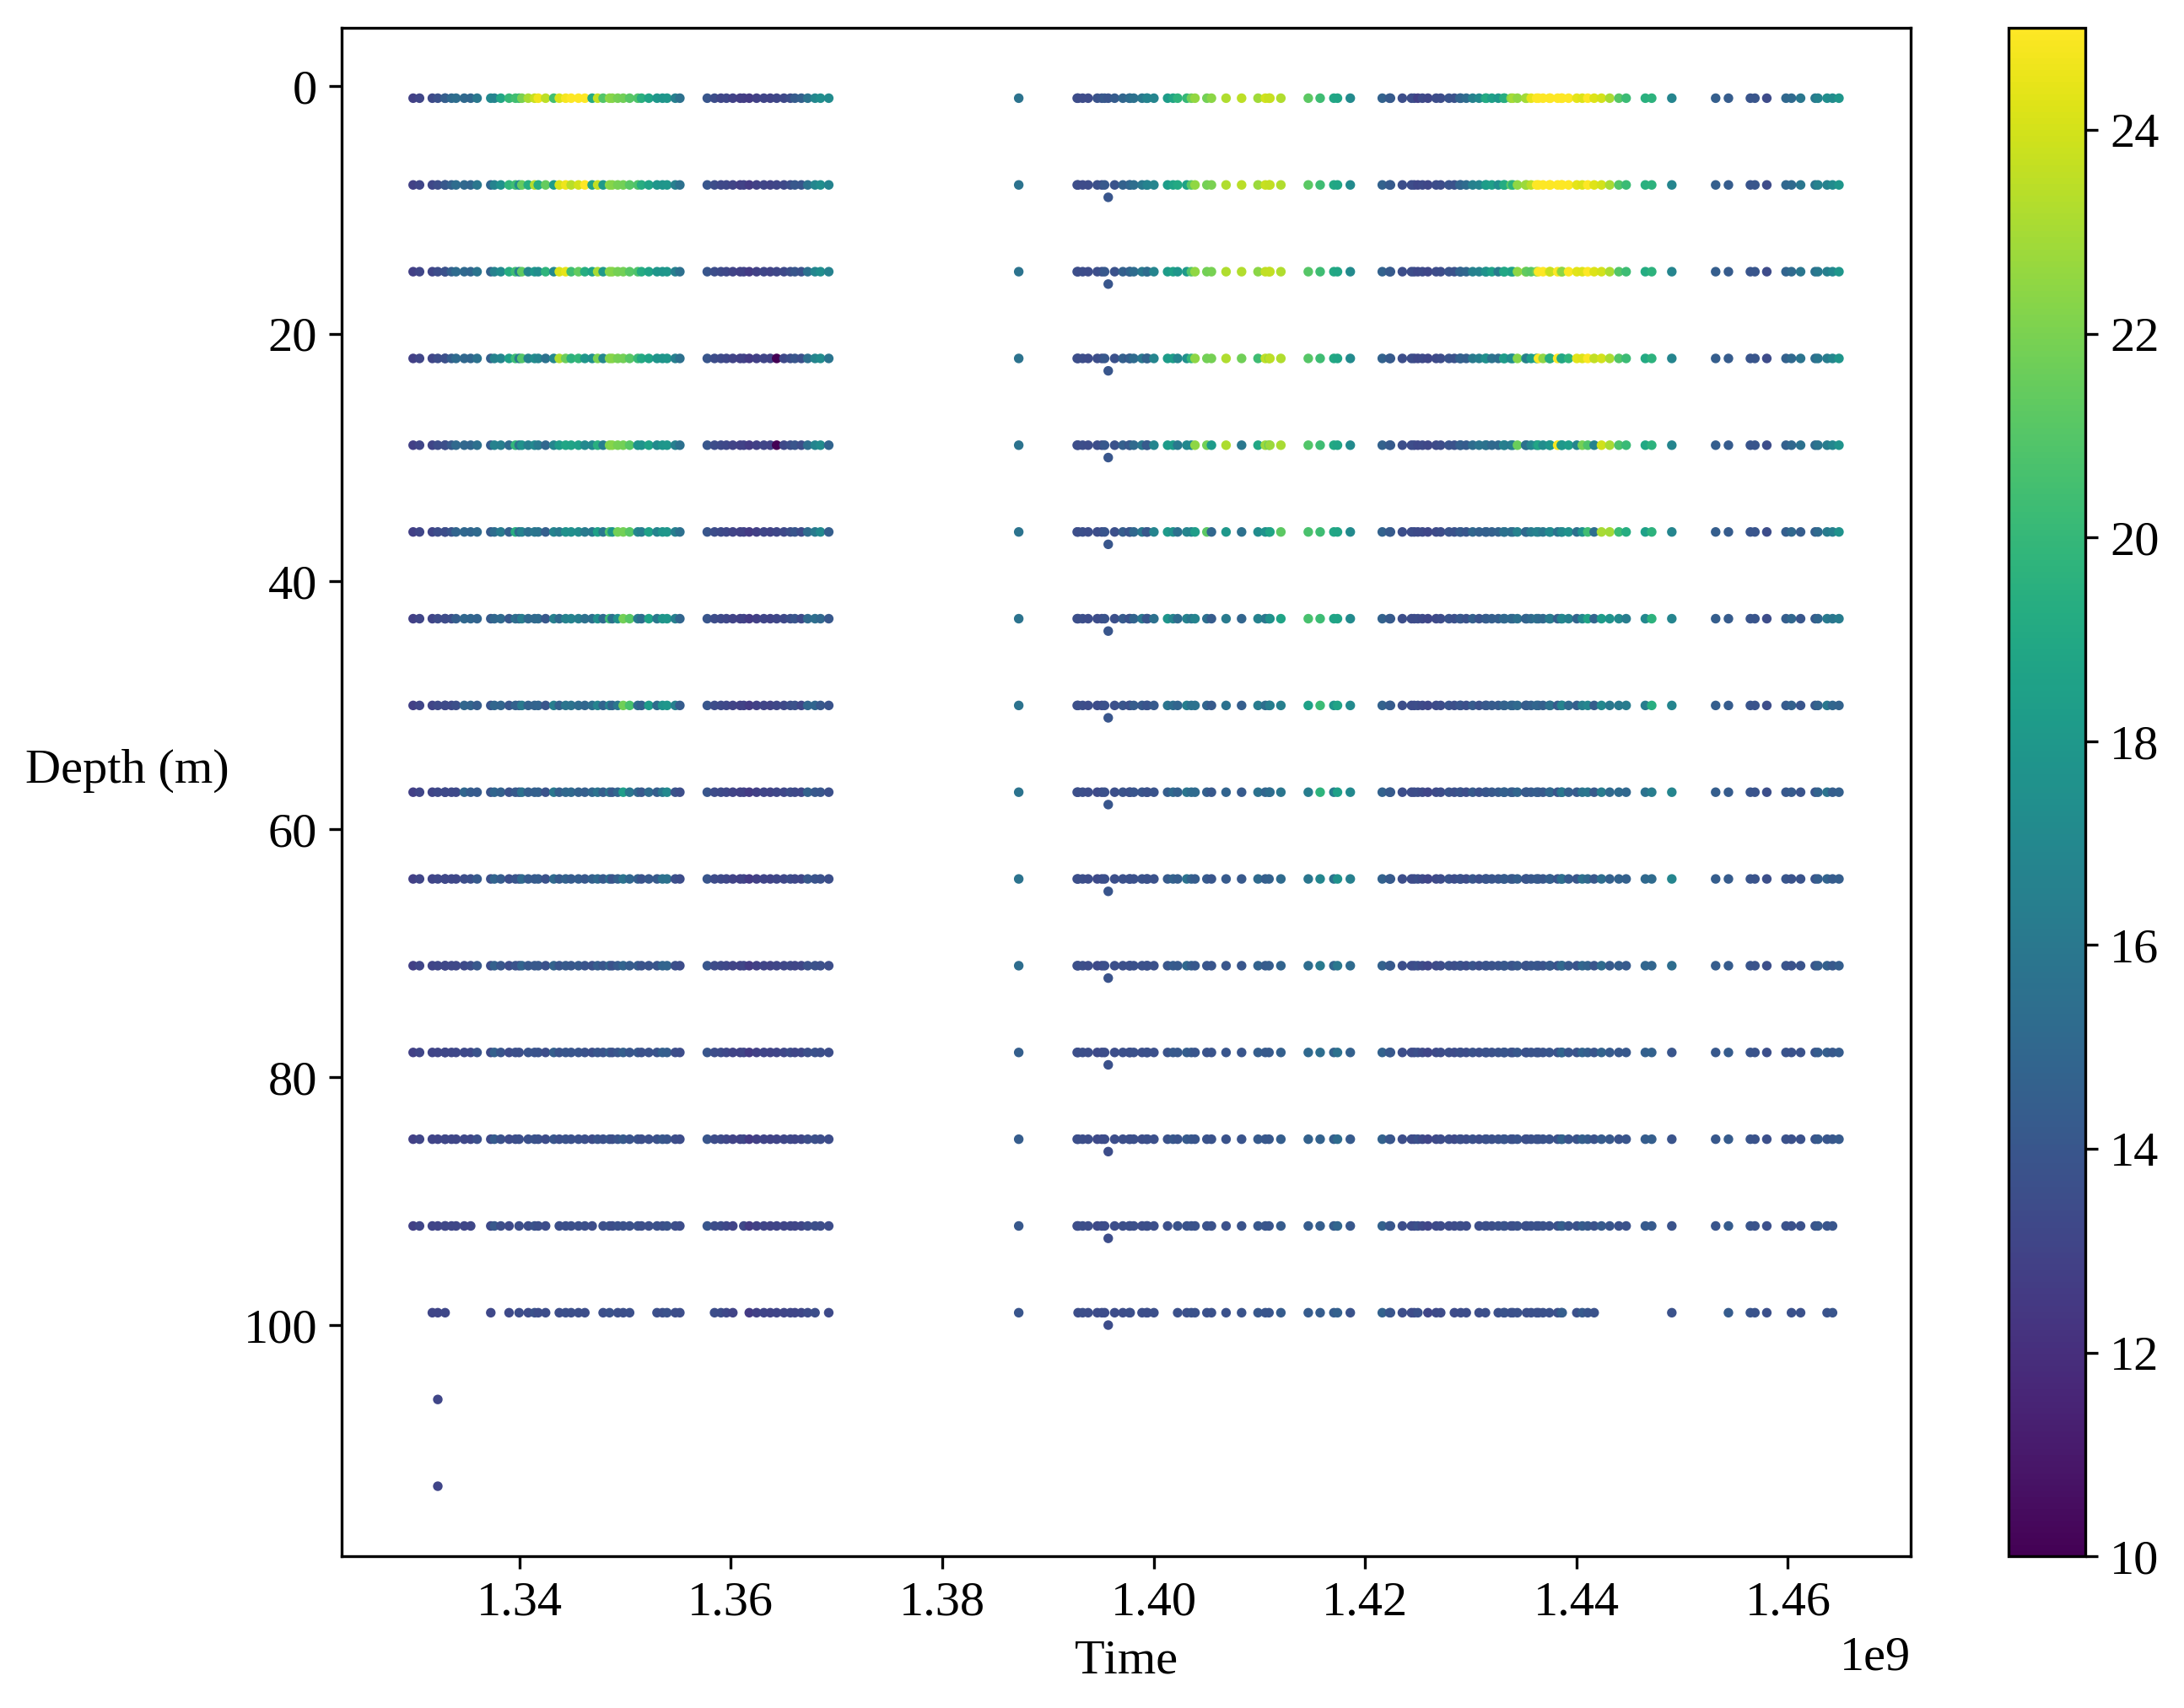

In [155]:
fig = plt.figure()
for datafile in datafilelist:
    P = CNVprofile(datafile)
    P.read_from_file()
    profiledate = P.get_date
    profiletime = calendar.timegm(profiledate.timetuple())
    plt.scatter(profiletime * np.ones_like(P.values['depth']), 
                P.values['depth'], 
                c=P.values['temperature'],
                s=3,
                vmin=10, vmax=25)
plt.colorbar()
plt.gca().invert_yaxis()
plt.xlabel('Time')
plt.ylabel('Depth (m)', rotation=0, ha='right')
figname = 'temperature_scatter'
plt.savefig(os.path.join(figdir, figname), bbox_inches='tight')
plt.show()
plt.close()

## Scatter plot (time - depth - salinity)

In [160]:
fig = plt.figure()
for datafile in datafilelist:
    P = CNVprofile(datafile)
    P.read_from_file()
    profiledate = P.get_date
    profiletime = calendar.timegm(profiledate.timetuple())
    plt.scatter(profiletime * np.ones_like(P.values['depth']), 
                P.values['depth'], 
                c=P.values['salinity'],
                s=3,
                vmin=37.5, vmax=38.5, cmap=plt.cm.RdYlBu_r)
plt.colorbar()
plt.gca().invert_yaxis()
plt.xlabel('Time')
plt.ylabel('Depth (m)', rotation=0, ha='right')
figname = 'salinity_scatter'
plt.savefig(os.path.join(figdir, figname), bbox_inches='tight')
#plt.show()
plt.close()